# Chatbot with Profile Schema 

## Review

We introduced the [LangGraph Memory Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore) as a way to save and retrieve long-term memories.

We built a simple chatbot that uses both `short-term (within-thread)` and `long-term (across-thread)` memory.

It saved long-term [semantic memory](https://langchain-ai.github.io/langgraph/concepts/memory/#semantic-memory) (facts about the user) ["in the hot path"](https://langchain-ai.github.io/langgraph/concepts/memory/#writing-memories), as the user is chatting with it.

## Goals

However, our chatbot saved memories as a string, simply overwriting the prior memory each time! 

In practice, we often want memories to have a structure. 
 
For example, memories can be a single, continuously updated ["profile"]((https://langchain-ai.github.io/langgraph/concepts/memory/#profile)) of well-scoped and specific information about a user. 

We also want to ensure that there is no information loss over time as we update our profile!
 
Here, we'll show how to save semantic memories to a [user profile](https://langchain-ai.github.io/langgraph/concepts/memory/#profile) and we'll introduce a useful library, [Trustcall](https://github.com/hinthornw/trustcall), for updating this profile. 

In [7]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph trustcall

In [9]:
import os, getpass

def _set_env(var: str):
    # Check if the variable is set in the OS environment
    env_value = os.environ.get(var)
    if not env_value:
        # If not set, prompt the user for input
        env_value = getpass.getpass(f"{var}: ")
    
    # Set the environment variable for the current process
    os.environ[var] = env_value

_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

## Defining a profile schema

Python has many different types for [structured data](https://python.langchain.com/docs/concepts/structured_outputs/#schema-definition), giving us the ability to save a user profile with a particular schema.

### JSON Schema

The simplest and most common format for structured output is a JSON-like structure.

In Python, this can be represented as a dictionary (dict) or list (list). 

JSON objects (or dicts in Python) are often used directly when the tool requires raw, flexible, and minimal-overhead structured data.


In [29]:
user_profile_json = {
  "type": "object",
  "properties": {
    "user_name": {
      "type": "string",
      "description": "The user's preferred name"
    },
    "interests": {
      "type": "array",
      "items": {"type": "string"},
      "description": "A list of the user's interests"
    }
  }
}

### Pydantic Schema

As a second example, [Pydantic](https://docs.pydantic.dev/latest/) is particularly useful for defining structured output schemas.

It offers type hints and validation. Here's an example of a Pydantic schema:

In [39]:
from pydantic import BaseModel, Field

class UserProfile(BaseModel):
    user_name: str = Field(description="The user's preferred name")
    interests: list = Field(description="A list of the user's interests")

### Saving a schema to the store

The [LangGraph Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore) supports any schema for the `value` part of the key-value pair. 

So, there is no problem saving a structured profile to the Store! 

Let's create an instance of each schema and save it to the Store.

In [31]:
# JSON Schema instance
user_instance_json = {
    "user_name": "Lance",
    "interests": ["biking", "technology", "coffee"]
}

# Pydantic Schema instance
user_instance_pydantic = UserProfile(
    user_name="Lance",
    interests=["biking", "technology", "coffee"]
)

We use the [put](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.put) method to save an object to the store by namespace and key.

In [32]:
import uuid
from langgraph.store.memory import InMemoryStore

# Initialize the in-memory store
in_memory_store = InMemoryStore()

# Namespace for the memory to save
user_id = "1"
namespace_for_memory = (user_id, "memories")

# Save a memory to namespace as key and value
key = str(uuid.uuid4())
value = user_instance_json
in_memory_store.put(namespace_for_memory, key, value)

key = str(uuid.uuid4())
value = user_instance_pydantic
in_memory_store.put(namespace_for_memory, key, value)

We use [search](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.search) to retrieve objects from the store by namespace.

We can see that the different schemas are saved their own keys.

In [33]:
# Search 
for m in in_memory_store.search(namespace_for_memory):
    print(m.dict())

{'value': {'user_name': 'Lance', 'interests': ['biking', 'technology', 'coffee']}, 'key': '7ecd7552-6430-4c90-9d60-286cdac2ac4f', 'namespace': ['1', 'memories'], 'created_at': '2024-10-26T17:32:08.667424+00:00', 'updated_at': '2024-10-26T17:32:08.667426+00:00'}
{'value': UserProfile(user_name='Lance', interests=['biking', 'technology', 'coffee']), 'key': '51f454f9-05bd-48dd-82b3-003cc82e288a', 'namespace': ['1', 'memories'], 'created_at': '2024-10-26T17:32:08.667501+00:00', 'updated_at': '2024-10-26T17:32:08.667502+00:00'}


## Writing schemas

Now we know how to specify a schema for the memories and save it to the store.

Now, how do we actually *create* memories with this particular schema?

In particular, we often need to [create memories from an unstructured chat with a user](https://langchain-ai.github.io/langgraph/concepts/memory/#profile). 

This is where the concept of [tool calling](https://python.langchain.com/docs/concepts/tool_calling/) is useful. 

It allows models to write [structured outputs](https://python.langchain.com/docs/concepts/structured_outputs/#recommended-usage) from unstructured inputs (e.g. a chat with a user).

[Many model providers support tool calling](https://python.langchain.com/docs/integrations/chat/) and LangChain's [chat model](https://python.langchain.com/docs/concepts/chat_models/) interface has a [`bind tools`](https://python.langchain.com/docs/concepts/tool_calling/#tool-binding) method to bind our schema to the model as a tool.

When appropriate, the model *can decide* to call this tool and [ensure its response conforms to the tool's schema](
https://python.langchain.com/docs/concepts/structured_outputs/#using-tool-calling). 

We'll be using this later when saving memories! 

In [42]:
_set_env("OPENAI_API_KEY")

In [40]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI

# Initialize the model
model = ChatOpenAI(model="gpt-4o", temperature=0)

# Bind UserProfile schema as a tool to the model
model_with_tools = model.bind_tools([UserProfile])

================================== Ai Message ==================================

Hello! How can I assist you today?


No tool calls are made because we don't have any personal information in the message.

In [ ]:
# Invoke the model
output = model_with_tools.invoke([HumanMessage("Hi!.")])
output.pretty_print()

Now, we invoke the model with personal information, which should trigger the tool call.

In [41]:
# Invoke the model with personal information, which should trigger the tool call
output = model_with_tools.invoke([HumanMessage("My name is Lance, I like to bike.")])
output.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  UserProfile (call_n3GA0yngBU0cNV6ssnA5vtv6)
 Call ID: call_n3GA0yngBU0cNV6ssnA5vtv6
  Args:
    user_name: Lance
    interests: ['biking']


It's also worth highlighting that LangChain provide [a helper function, `with_structured_output`](https://python.langchain.com/docs/concepts/structured_outputs/#recommended-usage), to enforce structured output.

This is useful when we want to enforce that the output conforms to a schema, and it parses the output for us.

In [38]:
# Bind schema to model
model_with_structure = model.with_structured_output(UserProfile)
# Invoke the model to produce structured output that matches the schema
structured_output = model_with_structure.invoke([HumanMessage("My name is Lance, I like to bike.")])
structured_output

UserProfile(user_name='Lance', user_location='Unknown', interests=['biking'])

## Updating schemas

Now we know how to use a model to write structured outputs, giving us the ability to save memories to a profile with a particular schema.

Now, we'll want to update this profile as we continue the conversation with the user.

What can go wrong? While working on memory over the past few months, we've seen some first-hand challenges.
  
In particular, information loss can occur when updating a schema. 

This is especially true if the schema contains a lot of information or has a complex structure.

This is because naive structure output generation, as shown above, will output the entire schema from scratch when making an update!

What if we could ask the model to only update the parts of the schema that have changed?

This is exactly the intuition behind [TrustCall](https://github.com/hinthornw/trustcall), an open-source library for updating JSON schemas developed by one of the engineers on the LangChain team, [Will Fu-Hinthorn](https://github.com/hinthornw).
 
Let's see how we can use TrustCall to create and update a user profile schema.

In [36]:
# Schema 
class UserProfile(BaseModel):
    """ Profile of a user """
    user_name: str = Field(description="The user's preferred name")
    user_location: str = Field(description="The user's location")
    interests: list = Field(description="A list of the user's interests")

Let's use TrustCall to create a user profile from the following conversation.

In [43]:
conversation = """User: Hi, I'm Lance.
Assistant: Nice to meet you, Lance.
User: I really like biking around San Francisco."""

To do this, we simply use `create_extractor`, passing in the model as well as our schema and a tool name.

And, we can invoke the extractor with the conversion as a list of messages.

In [45]:
from trustcall import create_extractor

trustcall_extractor = create_extractor(
    model,
    tools=[UserProfile],
    tool_choice="UserProfile",
)

# Instruction
instruction = f"""Extract the user profile from the following conversation:
<convo>
{conversation}
</convo>"""

# Invoke the extractor
result = trustcall_extractor.invoke({"messages": [HumanMessage(content=instruction)]})
existing_profile = result["responses"][0]
existing_profile

UserProfile(user_name='Lance', interests=['biking around San Francisco'])

In [40]:
existing_profile.model_dump()

{'user_name': 'Lance',
 'user_location': 'San Francisco',
 'interests': ['biking']}

Now what we've used TrustCall to create a user profile from a conversation, let's see how we can use it to update the profile.

When performing schema updates, TrustCall takes a set of messages as well as the existing JSON schema. 

It prompts the model to produce a [JSON Patch](https://jsonpatch.com/) based upon the messages and existing schema rather than naively creating the entire schema!

This is less error-prone than naively overwriting the entire schema and more efficient since it only updates the parts of the schema that have changed.

In [46]:
# Update the conversation
updated_conversation = """User: Hi, I'm Lance.
Assistant: Nice to meet you, Lance.
User: I really like biking around San Francisco.
Assistant: San Francisco is a great city! Where do you go after biking?
User: I really like to go to a bakery."""

# Update the instruction
updated_instruction = f"""Update the memory (JSON doc) to incorporate new information from the following conversation:
<convo>
{updated_conversation}
</convo>"""

# Invoke the extractor with the updated instruction and existing profile with the corresponding tool name (UserProfile)
result = trustcall_extractor.invoke({"messages": [HumanMessage(content=updated_instruction)], 
                                     "existing": {"UserProfile": existing_profile.model_dump()}})
updated_profile = result["responses"][0]
updated_profile

UserProfile(user_name='Lance', interests=['biking around San Francisco', 'go to a bakery'])

In [47]:
updated_profile.model_dump()

{'user_name': 'Lance',
 'interests': ['biking around San Francisco', 'go to a bakery']}

Let's walk through the LangSmith trace to show how TrustCall prompts the model to produce a JSON Patch to update the schema and performs validation. 

https://smith.langchain.com/public/b990b271-f570-40f5-927b-437b1287bca8/r
 
For more examples, you can see an overview video [here](https://www.youtube.com/watch?v=-H4s0jQi-QY) for more details on TrustCall.

In particular, we show a number of cases where TrustCall's JSON Path and validation checks are useful for creating and updating complex (e.g., nested) JSON schemas.


## Chatbot with memory creation and updating

Now, let's bring Trustcall into our existing chatbot to create and update memories.

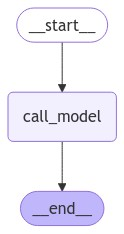

In [60]:
from IPython.display import Image, display

from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.runnables.config import RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.base import BaseStore

# Initialize the model
model = ChatOpenAI(model="gpt-4o", temperature=0)

# Schema 
class UserProfile(BaseModel):
    """ Profile of a user """
    user_name: str = Field(description="The user's preferred name")
    user_location: str = Field(description="The user's location")
    interests: list = Field(description="A list of the user's interests")

# Create the extractor
trustcall_extractor = create_extractor(
    model,
    tools=[UserProfile],
    tool_choice="UserProfile",
)

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("memories", user_id)

    # Retrieve the profile from the store using the key that we save the profile under
    profile = store.get(namespace, "user_profile")

    # Get the last message from the user 
    last_message = state["messages"][-1]

    # Check if it contains the keyword "remember"
    if "remember" in last_message.content.lower():
        
        # Get the profile as the value from the list, and convert it to a JSON doc
        existing_profile = {"UserProfile": profile.value} if profile else None

        # Instructions 
        instruction = f"""Create or update the memory (JSON doc) to incorporate information from the following conversation:
        <convo>
        {list(state['messages'])}
        </convo>"""
        
        # Invoke the extractor
        result = trustcall_extractor.invoke({"messages": [HumanMessage(content=instruction)], "existing": existing_profile})
        
        # Get the updated profile as a JSON object
        updated_profile = result["responses"][0].model_dump(mode="json")

        # Save the updated profile
        key = "user_profile"
        store.put(namespace, key, {"profile": updated_profile})

    # Format all memories for the system prompt
    system_msg = f"You are a helpful assistant. Here is relevant information about the user: {profile.value if profile else None}"
    
    # Invoke the model with the system prompt that contains the memories as well as the user's messages
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])
    return {"messages": response}

# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", END)

# Store from cross-thread memory
in_memory_store = InMemoryStore()

# We compile the graph with the checkpointer and store
graph = builder.compile(checkpointer=MemorySaver(), store=in_memory_store)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [61]:
# We supply a user ID for across-thread memory as well as a thread ID for within-thread memory
config = {"configurable": {"thread_id": "5", "user_id": "1"}}

# I give the chatbot a message to remember using the keyword "remember"
input_messages = [HumanMessage(content="Hi! Remember: my name is Lance")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi! Remember: my name is Lance
================================== Ai Message ==================================

Hi Lance! How can I assist you today?


In [62]:
# Continue the conversation
input_messages = [HumanMessage(content="Remember: I like to bike")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Remember: I like to bike
================================== Ai Message ==================================

Got it, Lance! You like to bike. Do you have any biking-related questions or topics you'd like to discuss?


In [63]:
# Define the namespace for the memories
namespace = ("memories", "1")

# Retrieve the profile from the store using the key that we save the profile under
profile = in_memory_store.get(namespace, "user_profile")
profile.dict()

{'value': {'profile': {'user_name': 'Lance',
   'user_location': '',
   'interests': ['bike']}},
 'key': 'user_profile',
 'namespace': ['memories', '1'],
 'created_at': '2024-10-26T18:38:08.304022+00:00',
 'updated_at': '2024-10-26T18:38:19.070316+00:00'}

TODO: Discuss Trustcall error with Will. 

https://smith.langchain.com/public/1c8a6873-7fae-4710-8303-d573dc51b595/r

In [64]:
# Continue the conversation
input_messages = [HumanMessage(content="Remember: I live in San Francisco")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Remember: I live in San Francisco


BadRequestError: Error code: 400 - {'error': {'message': "Invalid 'messages[0].tool_calls[0].function.name': string does not match pattern. Expected a string that matches the pattern '^[a-zA-Z0-9_-]+$'.", 'type': 'invalid_request_error', 'param': 'messages[0].tool_calls[0].function.name', 'code': 'invalid_value'}}

In [53]:
# Define the namespace for the memories
namespace = ("memories", "1")

# Retrieve the profile from the store using the key that we save the profile under
profile = in_memory_store.get(namespace, "user_profile")
profile.dict()

{'value': {'profile': {'user_name': 'Lance', 'interests': ['bike']}},
 'key': 'user_profile',
 'namespace': ['memories', '1'],
 'created_at': '2024-10-26T18:31:29.894374+00:00',
 'updated_at': '2024-10-26T18:31:45.718754+00:00'}

We can see that the profile is being updated as we continue the conversation!

## LangSmith 

We can view the chatbot's memory updates in LangSmith, and in particular see how TrustCall is used to update the memory.

https://smith.langchain.com/public/c422bbba-1320-4df6-853a-e654ca0ef5c9/r